In [1]:
#Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tfms
import torchvision.models as models
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Defining data transformations for training data
data_transforms = tfms.Compose([
        tfms.Resize(240),
        tfms.CenterCrop(240),
        tfms.ToTensor(),
    ])

In [4]:
# #creating datasets of real photos and sketches
real_dataset = datasets.ImageFolder('/content/drive/MyDrive/data_2/train_originals', data_transforms)
sketch_dataset = datasets.ImageFolder('/content/drive/MyDrive/train_ske/', data_transforms)
# #creating datasets of real photos and sketches
real_dataset_test = datasets.ImageFolder('/content/drive/MyDrive/data_2/test_originals', data_transforms)
sketch_dataset_test = datasets.ImageFolder('/content/drive/MyDrive/data_2/test_sketches', data_transforms)

In [5]:
# #creating datasets of real photos and sketches
# sketch_dataset = datasets.ImageFolder('/content/drive/MyDrive/data_2/train_originals', data_transforms)
# real_dataset = datasets.ImageFolder('/content/drive/MyDrive/train_ske/', data_transforms)
# #creating datasets of real photos and sketches
# sketch_dataset_test = datasets.ImageFolder('/content/drive/MyDrive/data_2/test_originals', data_transforms)
# real_dataset_test = datasets.ImageFolder('/content/drive/MyDrive/data_2/test_sketches', data_transforms)

In [6]:
print(real_dataset)

Dataset ImageFolder
    Number of datapoints: 3600
    Root location: /content/drive/MyDrive/data_2/train_originals
    StandardTransform
Transform: Compose(
               Resize(size=240, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(240, 240))
               ToTensor()
           )


In [7]:
#dataloaders for datasets
real_data_loader = torch.utils.data.DataLoader(real_dataset, batch_size=1, num_workers=4) 
sketch_data_loader = torch.utils.data.DataLoader(sketch_dataset, batch_size=4, num_workers=4) 
real_data_loader_test = torch.utils.data.DataLoader(real_dataset_test, batch_size=1, num_workers=4) 
sketch_data_loader_test = torch.utils.data.DataLoader(sketch_dataset_test, batch_size=4, num_workers=4) 

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


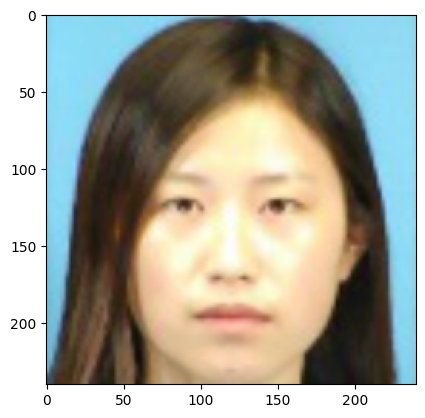

In [8]:
#real photo
imgs = next(iter(real_data_loader))
plt.figure()
plt.imshow(np.transpose(imgs[0][0].numpy(), (1, 2, 0)))
plt.show()

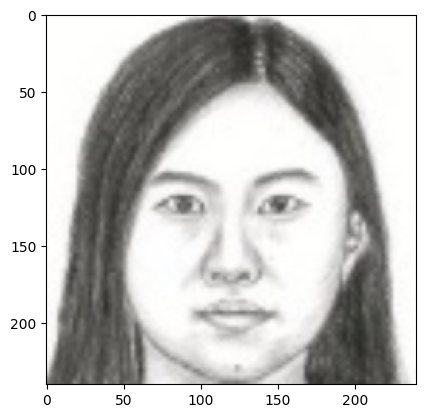

In [9]:
#sketch photo
imgs = next(iter(sketch_data_loader))
plt.figure()
plt.imshow(np.transpose(imgs[0][0].numpy(), (1, 2, 0)))
plt.show()

In [10]:
#Normal Residual block
class Res(nn.Module):
    def __init__(self):
        super(Res, self).__init__()
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out) + x
        
        return out

In [11]:
#Residual block without adding input at the end
class Res1(nn.Module):
    def __init__(self):
        super(Res1, self).__init__()
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        
        return out

In [12]:
#Defining our network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = nn.Sequential(nn.Conv2d(3, 32, 9, stride=1, padding=4),
                          nn.BatchNorm2d(32),
                          nn.ReLU())
        self.c2 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2, padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU())
        self.c3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU())
        
        self.res = nn.Sequential(Res1(), Res(), Res(), Res(), Res())
        
        self.d1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU())
        self.d2 = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
                          nn.BatchNorm2d(32),
                          nn.ReLU())
        self.d3 = nn.Sequential(nn.Conv2d(32, 3, 9, stride=1, padding=4),
                          nn.BatchNorm2d(3),
                          nn.Tanh())

    def forward(self, x):
        out = self.c1(x)
        out = self.c2(out) 
        out = self.c3(out) 
        out = self.res(out)
        out = self.d1(out)
        out = self.d2(out)
        out = self.d3(out)
        
        return out

In [13]:
#creating an instance of the network/model
model = Net().cuda()

In [14]:
#hyperparameters
lr = 0.001
num_epochs = 50

In [ ]:
#defining loss function, criterion and importing pretrained vgg16 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
model_vgg = models.vgg16(pretrained=True).cuda()

In [16]:
#removing last layer of vgg
removed = list(model_vgg.children())[:-1]
model_vgg = torch.nn.Sequential(*removed).cuda()

In [ ]:
#training for 50 epochs 
for epoch in range(num_epochs):
    total_loss = 0
    real_iter = iter(real_dataset)
    sketch_iter = iter(sketch_dataset) 
    for i, _ in enumerate(real_data_loader):
        real_img = next(real_iter)[0]
        reals = real_img.unsqueeze(0).cuda()
        sketch_img = next(sketch_iter)[0]
        sketches = sketch_img.unsqueeze(0).cuda()
        
        model.zero_grad()
        outs = model(sketches)
        
        with torch.no_grad():
            vgg_reals = model_vgg(reals)
        
        loss = criterion(outs, reals) + criterion(model_vgg(outs), vgg_reals)
                
        variation_loss = 0.00001 * (
                torch.sum(torch.abs(outs[:, :, :, :-1] - outs[:, :, :, 1:])) + 
                torch.sum(torch.abs(outs[:, :, :-1, :] - outs[:, :, 1:, :]))
            )
        
        loss += variation_loss
        loss.backward()
        
        total_loss += loss
        optimizer.step()
    print("Epoch", epoch, "Loss:", total_loss.data)

In [58]:
import cv2
import numpy as np

def calculate_psnr(img1, img2):
    # Load the images
    # img1 = cv2.imread(img1)
    # img2 = cv2.imread(img2)

    # Calculate the MSE (Mean Squared Error) for each channel
    mse_r = np.mean((img1[:,:,0] - img2[:,:,0]) ** 2)
    mse_g = np.mean((img1[:,:,1] - img2[:,:,1]) ** 2)
    mse_b = np.mean((img1[:,:,2] - img2[:,:,2]) ** 2)

    # Calculate the PSNR (Peak Signal-to-Noise Ratio) for each channel
    max_pixel_value = 255.0  # Assumes 8-bit images
    psnr_r = 10 * np.log10(max_pixel_value / mse_r)
    psnr_g = 10 * np.log10(max_pixel_value / mse_g)
    psnr_b = 10 * np.log10(max_pixel_value / mse_b)

    # Calculate the average PSNR across all channels
    psnr_avg = (psnr_r + psnr_g + psnr_b) / 3.0
    return psnr_avg


In [45]:
from skimage.metrics import structural_similarity as ssim
import torch



def calculate_ssim(img1, img2):
    # # Load the images
    # img1 = io.imread(img1_path, as_gray=True)
    # img2 = io.imread(img2_path, as_gray=True)
    # Calculate the SSIM
   # print(type(img1))
    ssim_l=[]
    ssim_l.append(ssim(img1[:,:,0], img2[:,:,0],data_range=img1.max() - img1.min()))
    ssim_l.append(ssim(img1[:,:,1], img2[:,:,1],data_range=img1.max() - img1.min()))
    ssim_l.append(ssim(img1[:,:,2], img2[:,:,2],data_range=img1.max() - img1.min()))
    return np.mean(ssim_l)


In [59]:
psnr_list=[]
ssim_list=[]
#iterators for the purpose of visualizing for well our model does
real_iter = iter(real_dataset_test)
sketch_iter = iter(sketch_dataset_test)
for i in range(0,236):
  real_img = next(real_iter)[0]
  sketch_img = next(sketch_iter)[0]
  
  cuda_img = sketch_img.unsqueeze(0).cuda()
  out = model(cuda_img)
  gen_img=np.transpose(out[0].clamp_(0,1).detach().cpu().numpy(), (1, 2, 0))
  real_img=np.transpose(real_img.detach().cpu().numpy(), (1, 2, 0))
  
  psnr=calculate_psnr(real_img, gen_img)
  psnr_list.append(psnr)
  ssim_value = calculate_ssim(real_img, gen_img)
  ssim_list.append(ssim_value)
  

In [60]:
print("Average PSNR(db) of all images is given by:",np.mean(psnr_list))
print("Average SSIM of all images is given by:",np.mean(ssim_list))

Average PSNR(db) of all images is given by: 42.721792715590745
Average SSIM of all images is given by: 0.6459761773821339


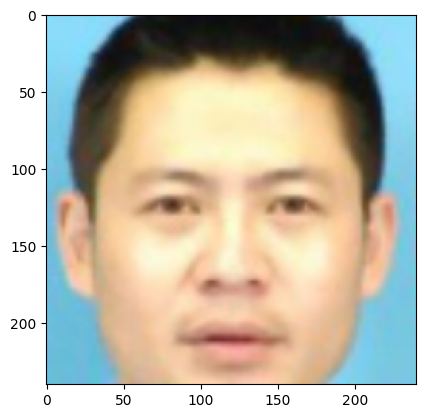

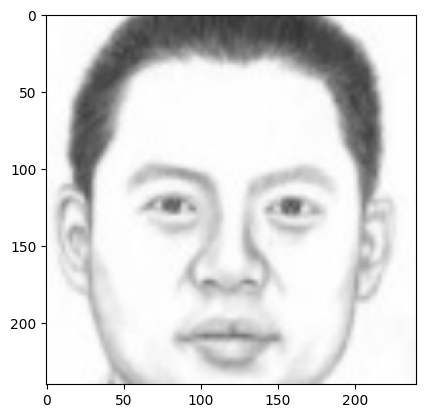

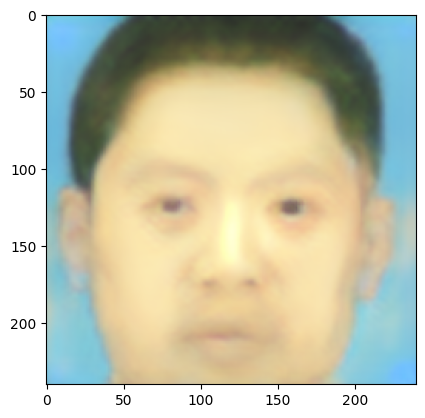

In [57]:
real_img = next(real_iter)[0]
sketch_img = next(sketch_iter)[0]

cuda_img = sketch_img.unsqueeze(0).cuda()
out = model(cuda_img)
#real image
plt.figure()
plt.imshow(np.transpose(real_img, (1, 2, 0)))
plt.show()

#sketch image
plt.figure()
plt.imshow(np.transpose(sketch_img, (1, 2, 0)))
plt.show()

#generated image
plt.figure()
plt.imshow(np.transpose(out[0].clamp_(0,1).detach().cpu().numpy(), (1, 2, 0)))
plt.show()

In [18]:
#loading previously saved model
model.load_state_dict(torch.load('classifier.pt'))
model =model.eval()

In [ ]:
#saving model
model_save_name = 'classifier.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)